In [1]:
import datetime
import os
import re
import numpy as np
from seabird import fCNV
import seapy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import scipy.io as sio
import cmaps
from matplotlib.colors import LinearSegmentedColormap

In [195]:
class insitu_workspace():
    def __init__(self,MY_ROOT,worksapce_name, workspace_detail=None):
        self.my_root = MY_ROOT
        self.workspace_name = worksapce_name
        self.workspace_detail = workspace_detail
        self.workspace_subdir = os.path.join(self.my_root, self.workspace_name)
        print('Workspace: ' + self.workspace_subdir)
        self.ctd_files = seapy.list_files(os.path.join(self.workspace_subdir+'/CTD/*acfld.cnv'))
        self.ctd_stationinfo = os.path.join(self.workspace_subdir,self.workspace_name+'-station.txt')
        self.isempty = True
        
        
    class Data():
        def __init__(self):
            self.filetype = 'ctd data structure'
            
            
    def pull_downcast(self,ctd_file,VAR):
        def lanczos_filter(data,Cf,Nf,M):
            coef = sp.signal.firwin(M+1, Cf/Nf,width = 2/len(data),window='lanczos', pass_zero='lowpass')
            return sp.signal.filtfilt(coef,1.0,data)

        dt = 0.04 #sec
        fs = 1/(dt)
        Nf = fs/2
        Cf = fs/1500
        M = 100
        print(ctd_file)
        profile = fCNV(ctd_file)
        time    = profile['timeS'][:]
        if VAR == 'PSAL2':
            var = profile.data[-6][:]
        else:
            var     = profile[VAR][:]
        pres    = profile['PRES'][:]
        depth   = profile['DEPTH'][:]
        # smooth the noise further
        pres_conv = np.convolve(pres,np.ones(24*6)/24/6,mode='full')[72:-71]
        pres_conv = seapy.filt.bandpass(pres_conv,dt,low_cutoff=dt*200,order=8)
        diff_pres = np.diff(pres_conv)
    #    diff_pres_conv = np.convolve(diff_pres,np.ones(24*6)/24/6,mode='full')[72:-71]
        diff_pres_conv = diff_pres.copy()
        count_down = 0
        count_up = 0
        for i in range(1,len(diff_pres_conv)):
            # print(diff_pres[i])
            # print(diff_pres[i]*diff_pres[i-1])
            if (diff_pres_conv[i]*diff_pres_conv[i-1]) < 0 :
                if diff_pres_conv[i-1]>0:
                    if  not count_down:
                        start_down = i
                    else:
                        start_down = np.r_[start_down, i]
                    count_down+=1
                else:
                    if not count_up :
                        start_up = i
                    else:
                        start_up = np.r_[start_up, i]
                    count_up+=1


    #        print(start_up)
    #        print(start_down)


        # print(pres[start_down[1]])
        larger = 1
        smaller = -1
        equal = 0
    #    print(len(start_down))
    #    print(len(start_up))
        if len(start_up) > len(start_down):
            end_indx = len(start_down)
            status = larger
        elif len(start_up) < len(start_down):
            end_indx = len(start_up)
            status = smaller
        else:
            status = equal


        if start_down[0] < start_up[0]:
            if status == equal:
                mono_duration = start_up[:-1] - start_down[1:]
            elif status == larger:
                mono_duration = start_up[:end_indx-1] - start_down[1:]
            elif status == smaller:
                mono_duration = start_up[:] - start_down[1:]
    #        print(mono_duration)
            downcast_index = np.argmax(np.abs(mono_duration))
    #        print(downcast_index)
            if ((pres[start_down[downcast_index+1]] -
                      pres[start_up[downcast_index]]) < 5):
                mono_duration[downcast_index] = 0
                downcast_index = np.argmax(np.abs(mono_duration))
            mono_duration[downcast_index] = 0

            downcast2_index = np.argmax(np.abs(mono_duration))

            if (downcast2_index > downcast_index)\
                and ((pres[start_down[downcast2_index+1]] - 
                      pres[start_up[downcast2_index]]) > 5):
                time_downcast = np.r_[
                                      time[start_up[downcast_index]:start_down[downcast_index+1]],
                                      time[start_up[downcast2_index]:start_down[downcast2_index+1]]

                                      ]
                pres_downcast = np.r_[
                                      pres[start_up[downcast_index]:start_down[downcast_index+1]],
                                      pres[start_up[downcast2_index]:start_down[downcast2_index+1]]
                                      ]
                depth_downcast = np.r_[
                                      depth[start_up[downcast_index]:start_down[downcast_index+1]],
                                      depth[start_up[downcast2_index]:start_down[downcast2_index+1]]
                                      ]
                var_downcast = np.r_[
                                       var[start_up[downcast_index]:start_down[downcast_index+1]],
                                       var[start_up[downcast2_index]:start_down[downcast2_index+1]]
                                    ]
            elif (downcast2_index < downcast_index)\
                and (((pres[start_down[downcast2_index+1]] - 
                      pres[start_up[downcast2_index]]) > np.max(pres) *0.4) \
                    and ((time[start_up[downcast_index]] -
                      time[start_down[downcast2_index+1]]) <np.max(time)*0.1))\
                    or (((pres[start_down[downcast2_index+1]] - 
                      pres[start_up[downcast2_index]]) > np.max(pres) *0.2) \
                    and ((time[start_up[downcast_index]] -
                      time[start_down[downcast2_index+1]]) <np.max(time)*0.05)):
                time_downcast = np.r_[
                                      time[start_up[downcast2_index]:start_down[downcast2_index+1]],
                                      time[start_up[downcast_index]:start_down[downcast_index+1]]

                                      ]
                pres_downcast = np.r_[
                                      pres[start_up[downcast2_index]:start_down[downcast2_index+1]],
                                      pres[start_up[downcast_index]:start_down[downcast_index+1]]
                                      ]
                depth_downcast = np.r_[
                                      depth[start_up[downcast2_index]:start_down[downcast2_index+1]],
                                      depth[start_up[downcast_index]:start_down[downcast_index+1]]
                                      ]
                var_downcast = np.r_[
                                       var[start_up[downcast2_index]:start_down[downcast2_index+1]],
                                       var[start_up[downcast_index]:start_down[downcast_index+1]]
                                    ]
            else:

                time_downcast = time[start_up[downcast_index]:start_down[downcast_index+1]]
                pres_downcast = pres[start_up[downcast_index]:start_down[downcast_index+1]]
                depth_downcast = depth[start_up[downcast_index]:start_down[downcast_index+1]]
                var_downcast = var[start_up[downcast_index]:start_down[downcast_index+1]]
                
            



        else:
            if status == equal:
                mono_duration = start_up - start_down
            elif status == larger:
                mono_duration = start_up[:end_indx] - start_down
            elif status == smaller:
                mono_duration = start_up[:] - start_down[:end_indx]

    #        print(mono_duration)
            downcast_index = np.argmax(np.abs(mono_duration))
    #        print(downcast_index)
            if ((pres[start_down[downcast_index]] -
                      pres[start_up[downcast_index]]) < 5):
                mono_duration[downcast_index] = 0
                downcast_index = np.argmax(np.abs(mono_duration))
            mono_duration[downcast_index] = 0
            downcast2_index = np.argmax(np.abs(mono_duration))
            if (downcast2_index > downcast_index)\
                and ((pres[start_down[downcast2_index]] - 
                      pres[start_up[downcast2_index]]) > 5):
                time_downcast = np.r_[
                                      time[start_up[downcast_index]:start_down[downcast_index]],
                                      time[start_up[downcast2_index]:start_down[downcast2_index]]

                                      ]
                pres_downcast = np.r_[
                                      pres[start_up[downcast_index]:start_down[downcast_index]],
                                      pres[start_up[downcast2_index]:start_down[downcast2_index]]
                                      ]
                depth_downcast = np.r_[
                                      depth[start_up[downcast_index]:start_down[downcast_index]],
                                      depth[start_up[downcast2_index]:start_down[downcast2_index]]
                                      ]
                
                var_downcast = np.r_[
                                       var[start_up[downcast_index]:start_down[downcast_index]],
                                       var[start_up[downcast2_index]:start_down[downcast2_index]]
                                    ]
            elif (downcast2_index < downcast_index)\
                and (((pres[start_down[downcast2_index]] - 
                      pres[start_up[downcast2_index]]) > np.max(pres)*0.4) \
                    and ((time[start_up[downcast_index]] -
                      time[start_down[downcast2_index]]) <np.max(time)*0.1))\
                  or (((pres[start_down[downcast2_index]] - 
                      pres[start_up[downcast2_index]]) > np.max(pres)*0.2) \
                    and ((time[start_up[downcast_index]] -
                      time[start_down[downcast2_index]]) <np.max(time)*0.05)) :
                time_downcast = np.r_[
                                      time[start_up[downcast2_index]:start_down[downcast2_index]],
                                      time[start_up[downcast_index]:start_down[downcast_index]]

                                      ]
                pres_downcast = np.r_[
                                      pres[start_up[downcast2_index]:start_down[downcast2_index]],
                                      pres[start_up[downcast_index]:start_down[downcast_index]]
                                      ]
                depth_downcast = np.r_[
                                      depth[start_up[downcast2_index]:start_down[downcast2_index]],
                                      depth[start_up[downcast_index]:start_down[downcast_index]]
                                      ]
                var_downcast = np.r_[
                                       var[start_up[downcast2_index]:start_down[downcast2_index]],
                                       var[start_up[downcast_index]:start_down[downcast_index]]
                                    ]
            else:

                time_downcast = time[start_up[downcast_index]:start_down[downcast_index]]
                pres_downcast = pres[start_up[downcast_index]:start_down[downcast_index]]
                depth_downcast = depth[start_up[downcast_index]:start_down[downcast_index]]
                var_downcast = var[start_up[downcast_index]:start_down[downcast_index]]
            
            
        return time_downcast.data, pres_downcast.data, depth_downcast.data, var_downcast.data

    def pull_ctdinfos(self):
        self.ctd_infos = {}
        ctdid = open(self.ctd_stationinfo)
        info = ctdid.readline().split()
        cid = 0
        while info:
            self.ctd_infos[info[1]]={}
            self.ctd_infos[info[1]]['TIME'] = (datetime.datetime.strptime(info[2],'%Y%m%d%H%M') - 
                                              datetime.datetime(1970,1,1)).total_seconds()/3600/24
            self.ctd_infos[info[1]]['LONGITUDE']=info[3]
            self.ctd_infos[info[1]]['LATITUDE']=info[4]
            self.ctd_infos[info[1]]['DEPTH'] = info[5]
            self.ctd_infos[info[1]]['CTDID'] = cid
            cid +=1
            info = ctdid.readline().split()
        ctdid.close()
        
    def pull_alldata(self,VARS):
        if self.isempty:
            self.data = {}
            self.isempty = False
        for iv, var in enumerate(VARS):
            self.data[var] = self.Data()
            for ic, ctd_file in enumerate(self.ctd_files):
                # print(ctd_file)
                ctdid = re.findall(r"%s/CTD/(.*)acfld.cnv"%(self.workspace_subdir),ctd_file)[0]
                print(ctdid)
                if ic == 0:
                    _, self.data[var].pres, self.data[var].depth, self.data[var].value = self.pull_downcast(ctd_file,var)
                    self.data[var].station = np.tile(self.ctd_infos[ctdid]['CTDID'],[len(self.data[var].value),]).ravel()
                    self.data[var].time = np.tile(float(self.ctd_infos[ctdid]['TIME']),[len(self.data[var].value),]).ravel()
                    self.data[var].lon = np.tile(float(self.ctd_infos[ctdid]['LONGITUDE']),[len(self.data[var].value),]).ravel()
                    self.data[var].lat = np.tile(float(self.ctd_infos[ctdid]['LATITUDE']),[len(self.data[var].value),]).ravel()
                    
                else:
                    _, thispres, thisdepth, thisvalue = self.pull_downcast(ctd_file,var)
                    thisstation = np.tile(self.ctd_infos[ctdid]['CTDID'],[len(thisvalue),]).ravel()
                    thistime = np.tile(float(self.ctd_infos[ctdid]['TIME']),[len(thisvalue),]).ravel()
                    thislon = np.tile(float(self.ctd_infos[ctdid]['LONGITUDE']),[len(thisvalue),]).ravel()
                    thislat = np.tile(float(self.ctd_infos[ctdid]['LATITUDE']),[len(thisvalue),]).ravel()
                    self.data[var].station  = np.r_[self.data[var].station ,thisstation]
                    self.data[var].time  = np.r_[self.data[var].time ,thistime]
                    self.data[var].pres  = np.r_[self.data[var].pres ,thispres]
                    self.data[var].depth = np.r_[self.data[var].depth,thisdepth]
                    self.data[var].value = np.r_[self.data[var].value,thisvalue]
                    self.data[var].lon   = np.r_[self.data[var].lon,thislon]
                    self.data[var].lat   = np.r_[self.data[var].lat,thislat]
                    
    
            
                    
                    
                   
                
                
            
        

15651.502083333333

In [196]:
test =insitu_workspace('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS','NSFC2012SPRING-YS','NSFC2012SPRING-YS')

Workspace: /Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-YS


In [197]:
test.pull_ctdinfos()

In [198]:
# must pull_ctdinfos before pull_alldata
test.pull_alldata(VARS=['TEMP',])

/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-YS/CTD/E01acfld.cnv
E01
/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-YS/CTD/E01acfld.cnv
/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-YS/CTD/E02acfld.cnv
E02
/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-YS/CTD/E02acfld.cnv
/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-YS/CTD/E03acfld.cnv
E03
/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-YS/CTD/E03acfld.cnv
/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-YS/CTD/E04acfld.cnv
E04
/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-YS/CTD/E04acfld.cnv
/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-YS/CTD/E05acfld.cnv
E05
/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-YS/CTD/E05acfld.cnv
/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-YS/CTD/H01acfld.cnv
H

In [98]:
test.data

{'DPSAL2': <__main__.insitu_workspace.Data at 0x7f9899b49580>,
 'PSAL2': <__main__.insitu_workspace.Data at 0x7f95d12c3dc0>,
 'TEMP': <__main__.insitu_workspace.Data at 0x7f959b692ac0>}

In [206]:
np.unique(test.data['TEMP'].station[station_position])

array([0, 1, 2, 3, 4])

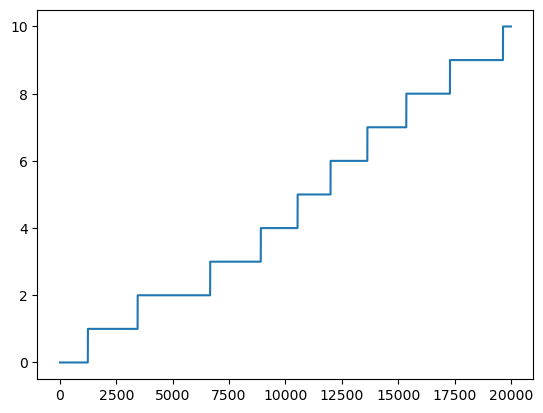

In [205]:
plt.plot(test.data['TEMP'].station[0:20000])

E01
0
[   0    1    2 ... 1231 1232 1233]
E02
1
[1234 1235 1236 ... 3438 3439 3440]
E03
2
[3441 3442 3443 ... 6655 6656 6657]
E04
3
[6658 6659 6660 ... 8901 8902 8903]
E05
4
[ 8904  8905  8906 ... 10533 10534 10535]


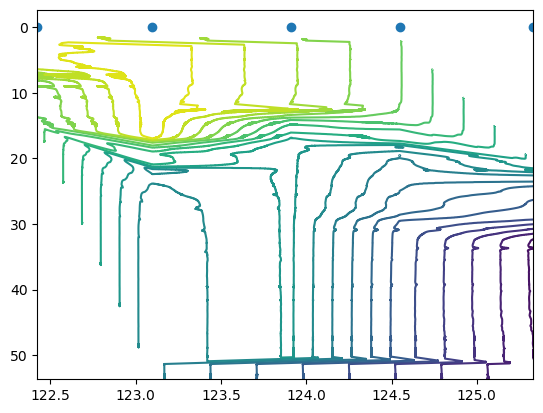

In [204]:
#temp profile
import matplotlib.tri as tri
VAR='TEMP'
stations = ['E01','E02','E03','E04','E05']
fig, ax = plt.subplots()
i = 0
for istation in stations:
    print(istation)
    print(test.ctd_infos[istation]['CTDID'])
    current_position = np.where(test.data[VAR].station == test.ctd_infos[istation]['CTDID'])[0]
    print(current_position)
    if i == 0:
        station_position = current_position.copy()
        
    else:
        station_position = np.r_[station_position,current_position]
        
    i+=1
    
lon_station = test.data[VAR].lon[station_position]
lat_station = test.data[VAR].lat[station_position]
depth_station = test.data[VAR].depth[station_position]
data_station = test.data[VAR].value[station_position]
ax.tricontour(lon_station,depth_station,data_station,levels=20)
ax.scatter(np.unique(lon_station),np.zeros_like(np.unique(lon_station)))
ax.invert_yaxis()
    

In [87]:
position = np.where(test.data['TEMP'].time==test.data['TEMP'].time[1])

In [91]:
seapy.seawater.depth(test.data['TEMP'].pres[position],test.data['TEMP'].lat[position])

array([ 1.6733532 ,  1.65547769,  1.64058143, ..., 14.99712619,
       14.98719599, 14.9772658 ])

In [92]:
test.data['TEMP'].depth[position]

array([ 1.673,  1.655,  1.641, ..., 14.997, 14.987, 14.977])

In [88]:
position

(array([   0,    1,    2, ..., 1231, 1232, 1233]),)

In [170]:
test.ctd_infos

{'E01': {'TIME': 15462.325694444444,
  'LONGITUDE': '122.4246',
  'LATITUDE': '31.2741',
  'DEPTH': '15.2400',
  'CTDID': 0},
 'E02': {'TIME': 15462.529861111112,
  'LONGITUDE': '123.0984',
  'LATITUDE': '31.2746',
  'DEPTH': '54.2400',
  'CTDID': 1},
 'E03': {'TIME': 15462.758333333333,
  'LONGITUDE': '123.9099',
  'LATITUDE': '31.2771',
  'DEPTH': '50.7500',
  'CTDID': 2},
 'E04': {'TIME': 15462.924305555556,
  'LONGITUDE': '124.5479',
  'LATITUDE': '31.2739',
  'DEPTH': '50.5900',
  'CTDID': 3},
 'E05': {'TIME': 15463.111111111111,
  'LONGITUDE': '125.3320',
  'LATITUDE': '31.2730',
  'DEPTH': '53.8100',
  'CTDID': 4},
 'H01': {'TIME': 15469.810416666667,
  'LONGITUDE': '121.0122',
  'LATITUDE': '35.9648',
  'DEPTH': '31.8900',
  'CTDID': 5},
 'H02': {'TIME': 15469.711805555555,
  'LONGITUDE': '121.3415',
  'LATITUDE': '35.9656',
  'DEPTH': '37.1700',
  'CTDID': 6},
 'H03': {'TIME': 15469.622222222222,
  'LONGITUDE': '121.6709',
  'LATITUDE': '35.9686',
  'DEPTH': '35.1200',
  'CTDI

In [54]:
test.ctd_files

['/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-YS/CTD/E01acfld.cnv',
 '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-YS/CTD/E02acfld.cnv',
 '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-YS/CTD/E03acfld.cnv',
 '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-YS/CTD/E04acfld.cnv',
 '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-YS/CTD/E05acfld.cnv',
 '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-YS/CTD/H01acfld.cnv',
 '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-YS/CTD/H02acfld.cnv',
 '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-YS/CTD/H03acfld.cnv',
 '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-YS/CTD/H04acfld.cnv',
 '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING-YS/CTD/H05acfld.cnv',
 '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/NSFC2012SPRING

In [67]:
sst_obs = seapy.roms.obs.obs(filename='/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/NOAA_GHRSST/geopolar_sst_201205.nc')

In [61]:
# merge sst and in-situ togethor
grdfile = '/Volumes/TO_1/outputs_SCORRECTION/ocean_ecs_fwd_15461_outer1.nc'
dt = 1/24
# reftime = datetime.datetime(1970,1,1)


In [13]:
grid = seapy.model.asgrid(grdfile)

In [63]:
data = [seapy.roms.obs.raw_data("TEMP", "CTD", test.data['TEMP'].value,None,0.1)]
        
insitu_obs = seapy.roms.obs.gridder(grid,test.data['TEMP'].time,
                                    test.data['TEMP'].lon,test.data['TEMP'].lat,
                                    -test.data['TEMP'].depth, data,dt,title="cruise obs")

Output()

In [68]:
sst_obs.add(insitu_obs)

In [69]:
sst_obs.to_netcdf('./combined_sst.nc')

In [66]:
pwd

'/Volumes/TO_1/roms4dvar_ecs/i4dvar_analysis/obs_processing'

array([371095.81666667, 371095.81666667, 371095.81666667, ...,
       371246.7       , 371246.7       , 371246.7       ])